In [1]:
from hamiltonian import Hamiltonian, HamiltonianH2, HamiltonianW

In [2]:
lih = Hamiltonian('LiH', 1.5)
beh2 = Hamiltonian('BeH2', 1.3)

h2_jw = HamiltonianH2('jw')
h2_parity = HamiltonianH2('parity')
h2_bk = HamiltonianH2('bk')

water_jw = HamiltonianW('jw')
water_parity = HamiltonianW('parity')
water_bk = HamiltonianW('bk')

The goal of this notebook is to render parallelise the computation of the variance.
`sparse.kron` is the expensive calculation. 

For each of the encodings `jw, parity, bk` I want to calculate the variances associated with `uniform, optimal, biased` where biased is associated with one of three norms: `1,2,infinity`.

There are therefore naturally $3*(1+1+3)$ calculations to do. And I have 15 cores at my disposal. Let's use them in parallel.


In [3]:
# build length-15 dictionary for molecule

# molecule = h2

encodings = {'jw': water_jw, 'parity': water_parity, 'bk': water_bk}
algos = {}
variances = {}
for encoding, ham in encodings.items():
    pr = ham.pauli_rep
    energy, state = pr.ground()
    
    variances[encoding+'_ell_1'] = ham.pauli_rep.variance_ell_1(energy)
    
    algo = encoding+'_uniform'
    algos[algo] = [algo, pr, energy, state, pr.local_dists_uniform()]  
    
    algo = encoding+'_optimal'
    algos[algo] = [algo, pr, energy, state, pr.local_dists_optimal()]  
    
    algo = encoding+'_1norm'
    algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm(1)]
    
    algo = encoding+'_2norm'
    algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm(2)]
    
    algo = encoding+'_maxnorm'
    algos[algo]   = [algo, pr, energy, state, pr.local_dists_pnorm('infinity')]

variances

/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


{'jw_ell_1': 4363.49777312609,
 'parity_ell_1': 4363.497773126077,
 'bk_ell_1': 4363.497773126094}

In [4]:
from multiprocessing import Pool
import multithread
if __name__ == '__main__':
    p = Pool(processes = 15)
    output = p.map(multithread.variance, algos.values())
    
    for algo, var in output:
        variances[algo] = var

In [5]:
variances

{'jw_ell_1': 4363.49777312609,
 'parity_ell_1': 4363.497773126077,
 'bk_ell_1': 4363.497773126094,
 'jw_uniform': 2839.0394682188676,
 'jw_optimal': 257.54509937271666,
 'jw_1norm': 2787.5103850564524,
 'jw_2norm': 9035.081653720712,
 'jw_maxnorm': 36696.29957121207,
 'parity_uniform': 6381.457574951584,
 'parity_optimal': 428.97854523129365,
 'parity_1norm': 87341.53226996149,
 'parity_2norm': 8377809.625550665,
 'parity_maxnorm': 79186313.22766103,
 'bk_uniform': 10563.644804714599,
 'bk_optimal': 1360.1824382833688,
 'bk_1norm': 73372.48149937576,
 'bk_2norm': 5961494.415695194,
 'bk_maxnorm': 82352030.35316804}

In [6]:
from matplotlib import pyplot as plt
import numpy as np

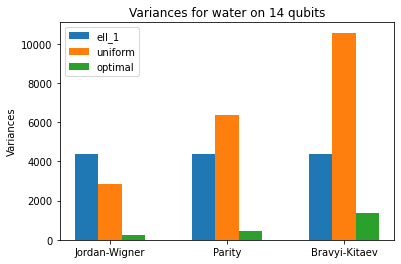

In [7]:
N = 3

ell_1_variances = [variances['{}_ell_1'.format(encoding)] for encoding in encodings]
uniform_variances = [variances['{}_uniform'.format(encoding)] for encoding in encodings]
optimal_variances = [variances['{}_optimal'.format(encoding)] for encoding in encodings]

ind = np.arange(N) 
width = 0.2       
plt.bar(ind, ell_1_variances, width, label='ell_1')
plt.bar(ind + width, uniform_variances, width, label='uniform')
plt.bar(ind + 2*width, optimal_variances, width, label='optimal')

plt.ylabel('Variances')
plt.title('Variances for water on 14 qubits')

plt.xticks(ind + width, ('Jordan-Wigner', 'Parity', 'Bravyi-Kitaev'))
plt.legend(loc='best')

plt.savefig('../images/variances_water_14qubits.png', dpi=300)
plt.show()